In [1]:
import numpy as np
from integrar import integrar_RK2, calcularRadioYMasa
import integrar
import bisect
import matplotlib.pyplot as plt

Physical constants in CGS units

In [2]:
c = 2.99792458e10 # velocidad de luz, cm/s
h = 6.6260755e-27 # constante de Planck, erg*s
G = 6.67259e-8 # constante de gravitacion, cm^3/g/s
e = 4.8032068e-10 # cargar del electron, esu
me = 9.1093897e-28 # masa del electron, g
mB = 1.66057e-24 # masa del baryon, g
Msol = 1.99e33 # masa del sol, g
Rsol = 6.96e10 # radio del sol, cm
km = 1e5 # cm

Function that performs linear interpolation

In [3]:
# xEn - x donde queremos obtener un valor d y
# xCuadricula - un array de valores de x
# yCuadricula - un array de valores de y en los lugares x
def interpolar(xEn, xCuadricula, yCuadricula):
    # get the upper indes
    i = bisect.bisect_right(xCuadricula, xEn, lo=0, hi=len(xCuadricula))

    # check for degenerate case
    yDerecha    = yCuadricula[i  ];
    xDerecha    = xCuadricula[i  ];
    yIzquierda  = yCuadricula[i-1];
    xIzquierda  = xCuadricula[i-1];
    if(yDerecha == yIzquierda):
        return yDerecha;

    # do the interpolation
    inclinacion = (yDerecha-yIzquierda) / (xDerecha-xIzquierda);
    ySalida = yIzquierda + (xEn-xIzquierda)*inclinacion;
    return ySalida;

yPrueba = 0.12962962962962965


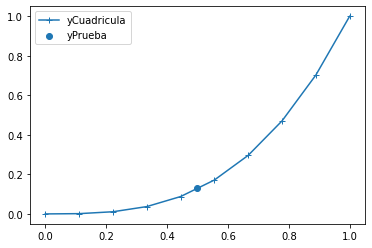

In [4]:
xCuadricula = np.linspace(0,1,10)
yCuadricula = xCuadricula**3
xPrueba = 0.5
yPrueba = interpolar(xPrueba, xCuadricula, yCuadricula)
plt.plot(xCuadricula, yCuadricula,marker="+",label="yCuadricula")
plt.scatter(xPrueba,yPrueba, label="yPrueba")
plt.legend()
print("yPrueba =", yPrueba)

Equation of state class

In [14]:
class EDE:
    def __init__(self, DensidadDeMasaMin, DensidadDeMasaMax, npoints):
        # crear array de densidad de masa
        log10DensidadDeMasaMin = np.log10(DensidadDeMasaMin)
        log10DensidadDeMasaMax = np.log10(DensidadDeMasaMax)
        dlog10DensidadDeMasa = (log10DensidadDeMasaMax - log10DensidadDeMasaMin) / (npoints-1)
        self.log10DensidadDeMasa = np.array([log10DensidadDeMasaMin + i*dlog10DensidadDeMasa for i in range(npoints)])
        DensidadDeMasa = 10**self.log10DensidadDeMasa # g/ccm

        # definir constantes para ecuacion 13 de Oppenheimer
        mB4 = mB*mB*mB*mB;
        c5 = c*c*c*c*c;
        h3 = h*h*h;
        K = np.pi*mB4*c5 / (4.*h3); # erg/ccm 
        
        # crear array de t, presion, densidad de energia
        phat = (DensidadDeMasa/mB * 3.*h3/(8.*np.pi))**(1./3.) / (mB*c)
        t = 4. * np.log(phat + np.sqrt(1.+phat*phat))
        DensidadTotal = K    * (np.sinh(t) - t) # erg/ccm
        Presion       = K/3. * (np.sinh(t) - 8.*np.sinh(t/2.) + 3.*t) # erg/ccm
        DensidadDeEnergia = DensidadTotal - DensidadDeMasa*c**2 # erg/ccm

        # crear arrays logaritmicos para interpolacion
        self.log10DensidadDeMasa    = np.log10(DensidadDeMasa)
        self.log10Presion           = np.log10(Presion)
        self.log10DensidadDeEnergia = np.log10(DensidadDeEnergia)

    def calcPresion(self,DensidadDeMasa): # erg/ccm
        x = np.log10(DensidadDeMasa)
        xgrid = self.log10DensidadDeMasa
        ygrid = self.log10Presion
        return 10**interpolar(x, xgrid, ygrid)
        
    def calcDensidadDeMasa(self,Presion): # g/ccm
        x = np.log10(Presion)
        xgrid = self.log10Presion
        ygrid = self.log10DensidadDeMasa
        return 10**interpolar(x, xgrid, ygrid)

    def calcDensidadDeEnergia(self, Presion): # erg/ccm
        x = np.log10(Presion)
        xgrid = self.log10Presion
        ygrid = self.log10DensidadDeEnergia
        return 10**interpolar(x, xgrid, ygrid)
    
    def calcDensidadTotal(self, Presion): # g/ccm
        return self.calcDensidadDeEnergia(Presion)/c**2 + self.calcDensidadDeMasa(Presion)
    
    def hacerGrafico(self):
        # hacer las curvas
        pres,  = plt.loglog(10**self.log10DensidadDeMasa, 10**self.log10Presion)
        edens, = plt.loglog(10**self.log10DensidadDeMasa, 10**self.log10DensidadDeEnergia)

        # hacer la leyenda
        plt.legend([pres,edens],["Presion","Densidad de Energia"])

        # poner la cuadricula
        plt.grid()

        # poner las etiquas de eje
        plt.xlabel("Densidad de Masa (g cm$^{-3}$)")
        plt.ylabel("Presion y Densidad de Energia (erg cm$^{-3}$)")

Haciendo una ecuacion de estado basado en presion de degeneracion de neutrones.

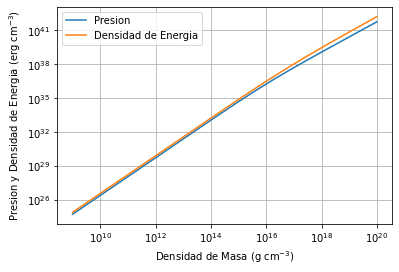

In [15]:
# inicializar la ecuacion de estadio.
# Solo nos importan las densidades entre 1e10 y 1e16 g/ccm,
# pero usamos un alcance mas grande para ver como queda.
# Calcular 200 puntas, entre de la clase EDE interpola.
ede = EDE(1e9, 1e20, 200)

# Hacer un grafico que mostra la ecuacion de estado
ede.hacerGrafico()

Equations of stellar structure

In [16]:
def dPresion_dr(r, DensidadTotal, Presion, MasaTotalInterna): # cm, g/ccm, erg/ccm, g
    result =  -G*MasaTotalInterna/r**2 * (DensidadTotal + Presion/c**2) * (1.0 + 4.*np.pi*Presion*r**3/(MasaTotalInterna*c**2)) / (1. - 2.*G*MasaTotalInterna/(r*c**2))
    return result # erg/ccm/cm
    
def dMasaTotalInterna_dr(r, DensidadTotal): # cm, g/ccm
    return 4.*np.pi*r**2 * DensidadTotal # g

Verify that we have calculated the derivatives properly

In [18]:
r = 1e5 # cm
DensidadDeMasa = 1e12 # g/ccm
Presion = ede.calcPresion(DensidadDeMasa) # erg/ccm
MasaTotalInterna = 1e33 # g

print("dPresion_dr esperado: ", 1.3770551299991524e+28)
print("dPresion_dr calculado: ", dPresion_dr(r, DensidadDeMasa, Presion, MasaTotalInterna))
print()
print("dMasaTotalInterna_dr esperado: ", 1.25663706144e+23)
print("dMasaTotalInterna_dr calculado: ",dMasaTotalInterna_dr(r, DensidadDeMasa))

dPresion_dr esperado:  1.3770551299991524e+28
dPresion_dr calculado:  1.3770551299991524e+28

dMasaTotalInterna_dr esperado:  1.25663706144e+23
dMasaTotalInterna_dr calculado:  1.2566370614359172e+23


In [19]:
# RK2 Integrador
def integrar_RK2(r0, Presion0, MasaTotalInterna0, dr, ede, tolerancia):

    # paso 0 - tambien necesitamos densidad total
    DensidadTotal0 = ede.calcDensidadTotal(Presion0)
    
    # paso 1 - haz medio paso usando numeros iniciales
    r1 = r0 + dr/2.
    dPdr0 =          dPresion_dr(r0, DensidadTotal0, Presion0, MasaTotalInterna0)
    dMdr0 = dMasaTotalInterna_dr(r0, DensidadTotal0)
    Presion1          =          Presion0 + dr/2. * dPdr0
    MasaTotalInterna1 = MasaTotalInterna0 + dr/2. * dMdr0
    DensidadTotal1 = ede.calcDensidadTotal(Presion1)
    
    # paso 2 - haz paso completo usando paso 1
    r2 = r0 + dr
    dPdr1 =          dPresion_dr(r1, DensidadTotal1, Presion1, MasaTotalInterna1)
    dMdr1 = dMasaTotalInterna_dr(r1, DensidadTotal1)
    Presion2          =          Presion0 + dr * dPdr1
    MasaTotalInterna2 = MasaTotalInterna0 + dr * dMdr1

    # calcular error, adjustar paso de longitud
    errorPresion          = abs(dPdr0 - dPdr1) / abs(dPdr0+dPdr1)
    errorMasaTotalInterna = abs(dMdr0 - dMdr1) / abs(dMdr0+dMdr1)
    error = max(errorPresion, errorMasaTotalInterna)
    dr = dr * (tolerancia/error)
    
    # queremos usar el paso 2
    return r2, Presion2, MasaTotalInterna2, dr

In [27]:
def calcularRadioYMasa(dr, tolerancia, DensidadDeMasaAlCentro, DensidadDeMasa_parar, ede, imprimir=False):
    # condiciones iniciales (al centro de la estrella)
    r = dr
    DensidadDeMasa = DensidadDeMasaAlCentro
    Presion = ede.calcPresion(DensidadDeMasa) # erg/ccm
    DensidadTotal = ede.calcDensidadTotal(Presion) # g/ccm
    MasaTotalInterna = 4./3. * np.pi * r**3 * DensidadTotal # g
    
    # hacer pasos hasta la densidad de masa esta demasiado pequeno
    i=0
    while DensidadDeMasa > DensidadDeMasa_parar:
        r, Presion, MasaTotalInterna, dr = integrar_RK2(r, Presion, MasaTotalInterna, dr, ede, tolerancia)
        DensidadDeMasa = ede.calcDensidadDeMasa(Presion)
        
        # imprimir el radio (km), la densidad de masa (g/ccm), y la masa total interna (g)
        if imprimir and i%1000==0:
            print(str(i)+"\t"+str(r/km)+"\t"+str(DensidadDeMasa)+"\t"+str(MasaTotalInterna/Msol))
        i = i+1
    if imprimir:
        print(str(i)+"\t"+str(r/km)+"\t"+str(DensidadDeMasa)+"\t"+str(MasaTotalInterna/Msol))
        
    return r, MasaTotalInterna

In [28]:
print("Paso   Radio(km)   DensidadDeMasa(g/ccm)   MasaTotalInterna(Msol)")

# constantes que determinan la caulidad de la calculacion
dr = 1 # cm
tolerancia = 1e-3
DensidadDeMasa_parar = 1e10

# Tratar de calcular la masa y radio de solo una estrella de neutrones
DensidadDeMasaAlCentro = 1e15
R, M = calcularRadioYMasa(dr, tolerancia, DensidadDeMasaAlCentro, DensidadDeMasa_parar, ede, True)

Paso   Radio(km)   DensidadDeMasa(g/ccm)   MasaTotalInterna(Msol)
0	2e-05	999999999994204.1	1.7738441795966753e-17
1000	0.00014694480256875888	999999999465949.1	7.261763322560127e-15
2000	0.0010803891873046056	999999970884417.9	2.8863847003432803e-12
3000	0.007943402546455135	999998425847605.9	1.1471835338580353e-09
4000	0.05840519493345313	999914901782349.9	4.559788991676953e-07
5000	0.4304322609803564	995388075366372.5	0.00018199624673614193
6000	3.813034065246235	694788683014583.4	0.10146487513297549
7000	11.253987326319882	22205140858605.824	0.6323278769637609
8000	12.642501642947204	516814322020.24725	0.6433638577455784
8991	12.774588264277787	9995707691.83614	0.6433935783148429


######################################################
# 5 - Calculando las Estructuras de Muchas Estrellas #
######################################################

DensidadDeMasaAlCentro(g/ccm)   Radio(km)   Masa(Msol)
100000000000000.12 20.844312474692774 0.312200450380403
115139539932644.64 20.29358561841555 0.3305357869777074
132571136559011.48 19.751008820621035 0.34953481722973206
152641796717523.7 19.216221200132253 0.3691561510569409
175751062485479.22 18.68925269732172 0.38934649439181385
202358964772515.34 18.169664176264057 0.4100396297601537
232995181051537.97 17.657444692257148 0.43115321752681635
268269579527972.9 17.152388741094875 0.45259439887813446
308884359647747.9 16.65436191062694 0.4742539680214835
355648030622314.44 16.163267441711437 0.4960076390053391
409491506238043.44 15.678990638475774 0.517716521230095
471486636345739.44 15.201579818316796 0.5392279066915884
542867543932385.0 14.73105876239126 0.5603765891719998
625055192527399.4 14.267457577285256 0.58098

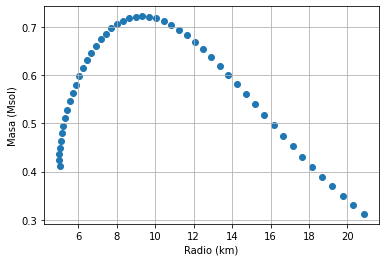

In [29]:
print("######################################################")
print("# 5 - Calculando las Estructuras de Muchas Estrellas #")
print("######################################################")
print()
print("DensidadDeMasaAlCentro(g/ccm)   Radio(km)   Masa(Msol)")

# Calcula la masa y radio de muchos estrellas de neutrinos y hacer un grafico
DensidadDeMasaAlCentro0 = 1e14 # g/ccm
DensidadDeMasaAlCentro1 = 1e17 # g/ccm
NumeroDeEstrellas = 50
DensidadesALosCentros = np.exp(np.linspace(np.log(DensidadDeMasaAlCentro0), np.log(DensidadDeMasaAlCentro1), NumeroDeEstrellas))
ListaDeR = []
ListaDeM = []
for iEstrella in range(NumeroDeEstrellas):
    DensidadDeMasaAlCentro = DensidadesALosCentros[iEstrella]
    R,M = calcularRadioYMasa(dr, tolerancia, DensidadDeMasaAlCentro, DensidadDeMasa_parar, ede, False)
    ListaDeR.append(R/km)
    ListaDeM.append(M/Msol)
    print(DensidadDeMasaAlCentro, R/km, M/Msol)
plt.grid()
plt.xlabel("Radio (km)")
plt.ylabel("Masa (Msol)")
plt.scatter(ListaDeR, ListaDeM)
plt.savefig("muchas_estrellas.pdf")
print("Grafico muchas_estrellas.pdf cargado.")